# Hyperband demo

Goals of this notebook:

* setup: show the problem, what we're trying to solve
* show Hyperband, a state-of-the-art algorithm for *hyperparameter optimization*
* show that Hyperband can be applied to other libraries (not only scikit-learn!)

This example notebook is modular.

## Table of contents
* [Problem setup](#Problem-setup)
* [Using Hyperband](#Using-Hyperband)
* [Evaluating Hyperband](#Evaluating-Hyperband)

Feel free to skip to any section to view that part.

## Problem setup

I am interested in *[image denoising]*. If I have a noisy image, can I remove the noise and recover the ground truth? To do that, I will use an [autoencoder], or a neural network that takes in noisy image the (hopefully) denoised image.

I will create the autoencoder in Keras, and give a simple wrapaper. Here cells that do that:

[autoencoder]:https://en.wikipedia.org/wiki/Autoencoder

In [1]:
import numpy as np

from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers
import keras.wrappers.scikit_learn
from keras.datasets import mnist
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
print(keras.__version__)

/Users/ssievert/anaconda3/envs/dask-master/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


2.2.0


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
def binary_crossentropy(target, output, epsilon=1e-7):
    # from https://github.com/keras-team/keras/blob/master/keras/backend/cntk_backend.py
    output = np.clip(output, epsilon, 1.0 - epsilon)
    return -target * np.log(output) - (1.0 - target) * np.log(1.0 - output)

from sklearn.base import BaseEstimator
import keras.backend as K

class ConvAutoencoder(BaseEstimator):
    def __init__(self, encoding_dim=32, lambduh=10e-6,
                 batch_size=32, optimizer='adadelta',
                 model_name='conv'):
        self.encoding_dim = encoding_dim
        self.lambduh = lambduh
        self.batch_size = batch_size
        self.optimizer = optimizer
        self.loss = binary_crossentropy
        self.model_name = model_name
        
        self.build_model()
        
    def build_model(self):
        input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

        x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
        x = MaxPooling2D((2, 2), padding='same')(x)
        x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
        encoded = MaxPooling2D((2, 2), padding='same')(x)

        # at this point the representation is (7, 7, 32)

        x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
        x = UpSampling2D((2, 2))(x)
        x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
        x = UpSampling2D((2, 2))(x)
        decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
            
        autoencoder = Model(input_img, decoded)
        autoencoder.compile(loss='binary_crossentropy',
                            optimizer=self.optimizer)
        self.autoencoder = autoencoder
    
    def partial_fit(self, X, X_noisy, y=None):
        # put in noisy images, get out clean images
        self.autoencoder.fit(X_noisy, X, shuffle=True,
                             epochs=1, batch_size=self.batch_size)
        
    def score(self, x, x_noisy):
        x_hat = est.autoencoder.predict(x_noisy)
        loss = self.autoencoder.loss_functions[0]
        
        x = K.constant(x)
        x_hat = K.constant(x_hat)
        losses_per_pixel = K.eval(loss(x, x_hat))
        losses = losses_per_pixel.reshape(-1, 28*28)
        return -1 * np.mean(losses)
    
    def predict(self, X):
        return self.autoencoder.predict(X)
    
class DenseAutoencoder(BaseEstimator):
    def __init__(self, encoding_dim=32, lambduh=10e-6,
                 batch_size=32, optimizer='adadelta',
                 model_name='conv'):
        self.encoding_dim = encoding_dim
        self.lambduh = lambduh
        self.batch_size = batch_size
        self.optimizer = optimizer
        
        self.build_model()
        
    def build_model(self):
        input_img = Input(shape=(784,))
        # add a Dense layer with a L1 activity regularizer
        encoded = Dense(self.encoding_dim, activation='relu',
                        activity_regularizer=regularizers.l1(self.lambduh))(input_img)
        decoded = Dense(784, activation='sigmoid')(encoded)

        autoencoder = Model(input_img, decoded)
        autoencoder.compile(loss='binary_crossentropy',
                            optimizer=self.optimizer)
        self.autoencoder = autoencoder
    
    def partial_fit(self, X, X_noisy, y=None):
        # put in noisy images, get out clean images
        self.autoencoder.fit(X_noisy, X, shuffle=True,
                             epochs=1, batch_size=self.batch_size)
        
    def score(self, x, x_noisy):
        x_hat = est.autoencoder.predict(x_noisy)
        loss = self.autoencoder.loss_functions[0]
        
        x = K.constant(x)
        x_hat = K.constant(x_hat)
        losses = K.eval(loss(x, x_hat))
        return -1 * np.mean(losses)
    
    def predict(self, X):
        return self.autoencoder.predict(X)
    
    def show_results(self, x, x_noisy):
        x_hat = self.predict(x_noisy)

        ncols, nrows = 8, 3
        w = 1.0
        fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*w, nrows*w))

        for k, (observ, estimate, truth) in enumerate(zip(x_noisy, x_hat, x)):
            if k > ncols - 1:
                break
            truth = np.reshape(truth, (28, 28))
            estimate = np.reshape(estimate, (28, 28))
            observ = np.reshape(observ, (28, 28))
            kwargs = {'cmap': 'gray', 'cbar': False, 'xticklabels': False, 'yticklabels': False}
            sns.heatmap(observ, ax=axs[0][k], **kwargs)
            sns.heatmap(estimate, ax=axs[1][k], **kwargs)
            sns.heatmap(truth, ax=axs[2][k], **kwargs)


And of course we have to apply this to data. We'll use the classic MNIST dataset.

In [3]:
def get_mnist(sigma=0.5):
    """
    Returns
    -------
    X_train : array-like
        Row for each digit. X.shape = (60e3, 784), 0 <= x.flat[i] <= 1
    y_train : array-like
    """
    
    (x_train, _), (x_test, _) = mnist.load_data()

    x_train = x_train.astype('float32') / 255.
    x_test = x_test.astype('float32') / 255.
    x_train = np.reshape(x_train, (len(x_train), 28*28))
    x_test = np.reshape(x_test, (len(x_test), 28*28))

    x_train_noisy = x_train + sigma*np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
    x_test_noisy = x_test + sigma*np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

    x_train_noisy = np.clip(x_train_noisy, 0., 1.)
    x_test_noisy = np.clip(x_test_noisy, 0., 1.)

    return (x_train, x_train_noisy), (x_test, x_test_noisy)

(x_train, x_train_noisy), (x_test, x_test_noisy) = get_mnist()

We can build and train our model with some chosen hyperparameters to see the expected output:

In [4]:
est = DenseAutoencoder(lambduh=1e-6, encoding_dim=64)
est.build_model()

In [85]:
for i in range(50):
#     print(i, est.score(x_test, x_test_noisy))
    est.partial_fit(x_train, x_train_noisy)

Epoch 1/1
30144/60000 [==============>...............] - ETA: 13s - loss: 0.2741

KeyboardInterrupt: 

## Show results

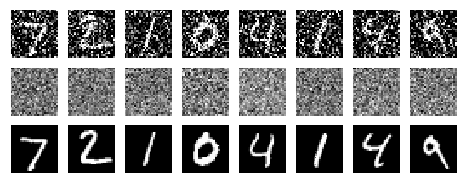

In [5]:
est.show_results(x_test, x_test_noisy)

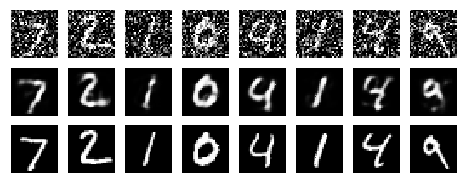